In [1]:
from IPython.display import display, HTML

import numpy as np
import pandas as pd

from pathlib import Path

from time import sleep

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, SGD, AdamW
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.initializers import glorot_uniform

2024-06-17 01:41:37.312037: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 01:41:37.315691: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 01:41:37.352756: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 01:41:38.280517: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
selected_bands = [f'B{x}' for x in range(2, 9)] + ['B8A', 'B11', 'B12', 'TCI_R', 'TCI_G', 'TCI_B']

In [3]:
model_dir = Path('models')
model_dir.mkdir(parents=True, exist_ok=True)

shards_dir = Path.home().joinpath('sentinel_data').joinpath('shards')

sort_key = lambda x: int(x.stem.split('_')[-1])
feature_filepaths = sorted(list(shards_dir.glob('feature_*.npy')), key=sort_key)

Adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [4]:
class DataGenerator(tf.keras.utils.PyDataset):
    'Generates data for Keras'
    def __init__(self, list_IDs, data_dir, shuffle, batch_size=32, dim=(100,100), n_channels=13,
                 n_classes=242, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.batch_size = batch_size
        self.data_dir = data_dir
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.use_multiprocessing = True
        self.workers = 8
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load(self.data_dir.joinpath(f'feature_{ID}.npy'))
            # Store class
            y[i] = np.load(self.data_dir.joinpath(f'label_{ID}.npy'))
        
        return X, y

In [5]:
class SleepCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        sleep(300)
    def on_epoch_begin(self, epoch, logs=None):
        if epoch > 1:
            sleep(300)  

In [6]:
class KerasModelCreator:
    def display_logger(self, log_file, metrics):
        metric_names = [m if isinstance(m, str) else m.name for m in metrics]
        if log_file.is_file():
            val_metrics = ['val_loss'] + ['val_' + x for x in metric_names]
            df = pd.read_csv(log_file)[['epoch', 'loss'] + metric_names + val_metrics]
            df['epoch'] += 1
            print('Previous training:')
            display(HTML(df.to_html(index=False)))
    
    def define_callbacks_and_logger(self, model_path, model_savepoint, log_file, metrics):
        metric_names = [m if isinstance(m, str) else m.name for m in metrics]

        callbacks = [
            tf.keras.callbacks.BackupAndRestore(
                model_savepoint, save_freq='epoch', delete_checkpoint=False
            ),
            tf.keras.callbacks.CSVLogger(log_file, append=True),
            tf.keras.callbacks.ModelCheckpoint(
                model_path, monitor='val_prc', save_best_only=True, 
                save_freq='epoch', initial_value_threshold=0.4,
                verbose=1,
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_prc', factor=0.6, patience=2, min_lr=3e-6,
                verbose=1,
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_prc', 
                verbose=1,
                patience=10,
                mode='max',
                restore_best_weights=True
            ),
            SleepCallback()
        ]
        return callbacks
    
    def get_initial_bias(self, shards_dir, IDs):
        all_labels = []
        for ID in IDs:
            f = shards_dir.joinpath(f'label_{ID}.npy')
            all_labels.append(np.load(f))
        all_labels = np.vstack(all_labels)
        neg, pos = np.bincount(all_labels.astype(int).flatten())
        return np.log([pos/neg])
    
    def res_block(self, x, filters):
        r = BatchNormalization()(x)
        r = Activation('relu')(r)
        r = Conv2D(
            filters=filters, kernel_size=3, strides=2, padding='same', 
            kernel_initializer=glorot_uniform(seed=42)
        )(r)
        
        r = BatchNormalization()(r)
        r = Activation('relu')(r)
        
        r = Conv2D(
            filters=filters, kernel_size=3, strides=1, padding='same', 
            kernel_initializer=glorot_uniform(seed=42)
        )(r)
        
        r = Conv2D(
            filters=1, kernel_size=1, strides=1, padding='valid'
        )(r)
        
        x = Conv2D(
            filters=filters, kernel_size=3, strides=2, padding='same', 
            kernel_initializer=glorot_uniform(seed=42)
        )(x)
        
        return Add()([x, r])
    
    def build_model(self, output_shape, input_shape, metrics, output_bias=None):
        if output_bias is not None:
            output_bias = tf.keras.initializers.Constant(output_bias)
         
        input_layer = Input(input_shape)
        
        base_units = 16
        
        x = self.res_block(input_layer, base_units)
        x = self.res_block(x, base_units*2)
        x = self.res_block(x, base_units*4)
        x = self.res_block(x, base_units*8)
        
        x = Activation('relu')(x)
        x = Flatten()(x)

        x = Dense(base_units*8, activation='relu')(x)
        x = Dense(output_shape, activation='sigmoid', bias_initializer=output_bias)(x)
        
        m = Model(inputs=input_layer, outputs=x)

        m.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
        
        return m
    
    def run(self, shards_dir, IDs, model_path, batch_size=10, epochs=10, overwrite=False):
        ''' 
        If not overwrite and there's an existing model, the model will 
        continue trainingw if the given epoch is bigger than the previous,
        else just evaluate.
        Ensure train splits are the same across continuations / evaluations
        by not modifying the random_state in split_and_normalise.
        '''
        model_savepoint = model_path.parent.joinpath(model_path.stem)
        log_file = model_path.with_suffix('.log')
        
        prc = tf.keras.metrics.AUC(name='prc', curve='PR')
        metrics = [
            'accuracy', 'recall', 'precision',
            'mse', 'auc', prc
        ]       

        if overwrite:
            for f in [model_path, log_file] + list(model_savepoint.glob('*')):
                f.unlink(missing_ok=True)
                
        self.display_logger(log_file, metrics)
        
        callbacks = self.define_callbacks_and_logger(
            model_path, model_savepoint, log_file, metrics)
        
        params = {
            'dim': (100, 100),
            'batch_size': batch_size,
            'n_classes': 242,
            'n_channels': 13
        }
        
        training_ids, test_ids = train_test_split(IDs, test_size=0.1, random_state=42)
        validation_ids, test_ids = train_test_split(test_ids, test_size=0.9, random_state=42)
        
        training_generator = DataGenerator(training_ids, shards_dir, shuffle=True, **params)
        testing_generator = DataGenerator(test_ids, shards_dir, shuffle=False, **params)
        validation_generator = DataGenerator(validation_ids, shards_dir, shuffle=False, **params)
        
        print('Loading model...')
        if model_path.is_file():
            model = load_model(model_path)
        else:
            initial_bias = self.get_initial_bias(shards_dir, IDs[:2000])
            model = self.build_model(
                params['n_classes'], (*params['dim'], params['n_channels']), metrics,
                output_bias=initial_bias,
            )
        print('Fitting...')
        model.fit(
            x=training_generator,
            validation_data=validation_generator,
            epochs=epochs,
            callbacks=callbacks
        )
        return model, testing_generator

In [7]:
parts = [f.stem.split('_')[-1] for f in feature_filepaths][:128000]
model_name = f'conv_parts_{parts[0]}_to_{parts[-1]}.keras'

model_path = model_dir.joinpath(model_name)
print(model_path)

IDs = [int(f.stem.split('_')[-1]) for f in feature_filepaths]
IDs = shuffle(IDs, random_state=42)

models/conv_parts_0_to_127999.keras


In [8]:
model, testing_generator = KerasModelCreator().run(
    shards_dir,
    IDs, 
    model_path, 
    batch_size=100, 
    epochs=4,
    overwrite=False
)

Previous training:


epoch,loss,accuracy,recall,precision,mse,auc,prc,val_loss,val_accuracy,val_recall,val_precision,val_mse,val_auc,val_prc
1,1.535452e-03,0.694861,0.957308,0.995679,3.366749e-04,0.999333,0.989803,8.925624e-08,0.726667,1.0,1.0,2.466766e-12,1.0,1.0
2,3.011879e-04,0.774688,0.992690,0.996915,6.865377e-05,0.999522,0.998631,4.764161e-08,0.855833,1.0,1.0,1.387700e-12,1.0,1.0
3,2.471961e-05,0.933160,0.999529,0.999683,5.047783e-06,0.999962,0.999875,4.174500e-09,0.957500,1.0,1.0,1.406186e-14,1.0,1.0
4,1.131117e-09,0.973446,1.000000,1.000000,3.914022e-14,1.000000,1.000000,3.390414e-11,1.000000,1.0,1.0,5.565322e-19,1.0,1.0


Loading model...
Fitting...


In [9]:
eval_path = model_path.with_suffix('.eval.csv')
if eval_path.is_file():
    print(pd.read_csv(eval_path))
else:
    r = model.evaluate(x=testing_generator, verbose=1, return_dict=True)
    df = pd.DataFrame.from_dict(r, orient='index', columns=['score'])
    df.to_csv(eval_path)
    print(df)

  Unnamed: 0     score
0   accuracy  0.812639
1        auc  0.867714
2       loss  0.186616
3        mse  0.002766
4        prc  0.722153
5  precision  0.951009
6   r2_score       NaN
7     recall  0.730435


In [10]:
preds_path = model_path.with_suffix('.preds.npy')
if preds_path.is_file():
    y_pred = np.load(preds_path)
else:
    y_pred = model.predict(x=testing_generator, verbose=1)
    np.save(preds_path, y_pred)

In [11]:
labels_path = model_path.with_suffix('.true.npy')
if labels_path.is_file():
    y_true = np.load(labels_path)
else:
    y_true = np.concatenate([y for x, y in testing_generator])
    np.save(labels_path, y_true)

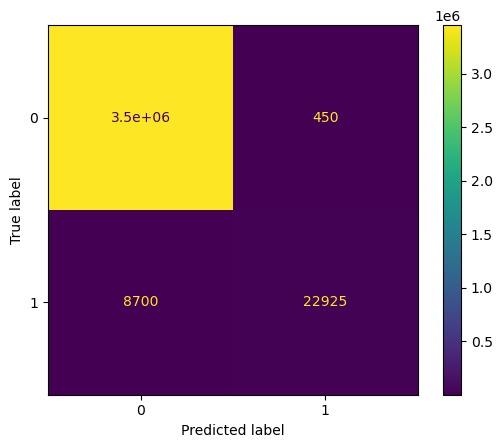

In [12]:
cm = confusion_matrix(y_true.flatten().astype(int), y_pred.flatten().astype(int))
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [13]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
# model.summary()

In [15]:
# tf.keras.models.load_model(model_path).summary()

In [16]:
# import subprocess
# subprocess.run(['sudo', 'shutdown', 'now'])